# Visualization: Congressional Bills

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import urllib
import codecs
import zipfile

import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import gridspec

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [3]:
# Download zipped dataset. YOU MUST BE CONNECTED TO THE INTERNET FOR THIS STEP.
url = 'http://congressionalbills.org/billfiles/bills93-114.zip'
filename = 'bills93-114.csv'
filepath = 'data/'+filename+'.zip'
if not os.path.isfile(filepath):
    with open(filepath, 'wb') as f:
            f.write(urllib.request.urlopen(url).read())

## Load and process dataset

In [4]:
# Load dataframe.
with zipfile.ZipFile(filepath) as zf:
    with zf.open(filename) as f:
        old_df = pd.read_csv(f, sep=';', encoding='latin-1')

In [5]:
text_cols = ['Title']
bool_cols = ['Gender', 'Party', 'Majority']
cat_cols = ['Major']
tgt_cols = ['PLaw']

In [6]:
## FEATURE PROCESSING
# Drop 50k bills that have missing data in one of the cols.
df = old_df[text_cols+bool_cols+cat_cols+tgt_cols].dropna()
# Remove 8 non-party-affiated bills.
df = df[df['Party'] != 328.0]
# Process categorical columns.
df['Party'] = df['Party'].map(lambda k: {100.0: 1, 200.0: 0}[k])
df['Major'] = df['Major'].map(lambda k: 'm'+str(int(k)))
# Fit tf-idf vectorizer on all data.
vec = TfidfVectorizer(sublinear_tf=True, smooth_idf=False)
vec.fit(df[text_cols].values.reshape(-1))
# Fit categorical encoder.
enc = preprocessing.OneHotEncoder()
enc.fit(df[cat_cols])
pass

In [7]:
def process_df(df,
               cat_cols=['Major'],
               bool_cols=['Gender', 'Party', 'Majority'],
               text_col='Title',
               tgt_col='PLaw'):

    # get categorical and boolean features.
    bool_dset = 2 * df[bool_cols].values - 1
    if len(cat_cols) > 0:
        cat_dset = enc.transform(df[cat_cols]).todense().A
        var_dset = np.concatenate([cat_dset, bool_dset], axis=1)
    else:
        var_dset = bool_dset
    sp_dset = sp.csr_matrix(var_dset)
    
    # get text features.
    if text_col is not None:
        text_dset = vec.transform(df[text_col].values.reshape(-1))
        
        dset = sp.csr_matrix(sp.hstack([text_dset, sp_dset]))
    else:
        dset = sp_dset
    
    target = df[tgt_col].values.reshape(-1)
    return dset, target

In [8]:
## For class balancing, subsample an even number of bills that did and did not become law.
df_p = df[df['PLaw'] == True]
n_pos = len(df_p)
df_n = df[df['PLaw'] == False].sample(n_pos)
small_df = pd.concat([df_p, df_n])
# small_df = df.sample(50000) # alternative: simply subsample.
# Split into train / dev set.
train_df, dev_df = train_test_split(small_df, test_size=0.5)
# Process data.
trnX, trnY = process_df(train_df)
devX, devY = process_df(dev_df)

## Construct and train model

In [9]:
# Construct logistic regression.
cls = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000, C=3)
cls.fit(trnX, trnY)

# evaluate the model.
yp = cls.predict(devX)
acc = metrics.accuracy_score(devY, yp)
f1 = metrics.f1_score(devY, yp)
print('acc: %.3f, f1: %.3f' % (acc, f1))

acc: 0.755, f1: 0.756


## Visualize Prediction Logic

In [10]:
vec.inv_vocab = {k: w for w, k in vec.vocabulary_.items()}
enc.inv_categ = {c: i for i, c in enumerate(enc.categories_[0])}
num_bool = 3
num_cat = enc.categories_[0].size
num_text = len(vec.vocabulary_)
assert num_bool + num_cat + num_text == cls.coef_.size
bool_coef = cls.coef_[0, -num_bool:]
cat_coef = cls.coef_[0, -(num_bool+num_cat):-num_bool]
text_coef = cls.coef_[0, :num_text]
assert bool_coef.size + cat_coef.size + text_coef.size == cls.coef_.size

def process_sentence(row):
    # extract words from the sentence that are used by our model,
    # and compute the contribution  of each word to the final score.
    text_embed = vec.transform([row['Title']])
    indices = sp.find(text_embed)[1]
    words = [vec.inv_vocab[i] for i in indices]
    text_wgts = np.array([text_embed[0, i] * text_coef[i] for i in indices])
    
    # categorical feature
    topic = row['Major']
    cat_embed = enc.transform([[topic]])
    cat_wgt = cat_coef[enc.inv_categ[topic]]
    
    # boolean features
    bool_embed = 2 * row[['Gender', 'Party', 'Majority']].values.astype('int') - 1
    bool_wgts = bool_coef * bool_embed
    
    # collect features and weights
    features = (words, topic, bool_embed)
    weights = (text_wgts, cat_wgt, bool_wgts)
    
    # test that the score from our weights matches that produced by the model.
    embed = sp.hstack([text_embed, cat_embed, bool_embed])
    pred = cls.predict_proba(embed)[0, 1]
    z = sum(w.sum() if len(w.shape) > 0 else w for w in weights) + cls.intercept_[0]
    assert np.abs(1 / (1 + np.exp(-z)) - pred) < 1e-5
    
    return features, weights, pred

In [11]:
def display_contributions(features, weights, pred):
    # split features
    words, topic, bool_feats = features
    word_wgts, cat_wgt, bool_wgts = weights
    
    # split into positive and negative local sentiment
    word_pos, wgt_pos = zip(*[(word, w) for word, w in zip(words, word_wgts) if w > 0])
    word_neg, wgt_neg = zip(*[(word, -w) for word, w in zip(words, word_wgts) if w < 0])
    wgt_pos, wgt_neg = np.array(wgt_pos), np.array(wgt_neg)
    # convert to pie chart radius
    get_radius = lambda v: 1.5 * np.sqrt(v) / np.pi
    rad_pos, rad_neg = get_radius(wgt_pos.sum()), get_radius(wgt_neg.sum())

    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(2, 3, width_ratios=[7, 1, 7], height_ratios=[7, 3])

    ax1 = plt.subplot(gs[0])
    ax1.pie(wgt_pos / wgt_pos.sum(), labels=word_pos, radius=rad_pos)
    ax1.set_title('Positive contributions to log-odds')

    ax2 = plt.subplot(gs[2])
    ax2.pie(wgt_neg / wgt_neg.sum(), labels=word_neg, radius=rad_neg)
    ax2.set_title('Negative contributions to log-odds')

    ev = np.log(pred / (1 - pred))
    ax3 = plt.subplot(gs[1])
    ax3.bar([0], [ev], width=0.01, color=['red', 'green'][int(ev > 0)])
    ax3.set_ylim([-5, 5])
    ax3.set_title('Predicted log(p/1-p)')
    ax3.set_xticklabels([])
    ax3.set_xticks([])
    ax3.set_yticks(np.arange(-5, 6))
    
    ind = [0, 1, 2]
    onoff = ['red', 'green']
    ax4 = plt.subplot(gs[3])
    for i, wgt in enumerate(bool_wgts):
        r = get_radius(abs(wgt))
        x = (i-1)*4
        c = plt.Circle((x, 0), 5.5*r, color=onoff[int(wgt > 0)])
        ax4.add_artist(c)
        ind = (bool_feats[i]+1)//2
        if i == 0:
            txt = 'Gender=%s' % ['Male', 'Female'][ind]
        if i == 1:
            txt = 'Party=%s' % ['Repubican', 'Democrat'][ind]
        if i == 2:
            txt = 'Majority=%s' % bool(ind)
        ax4.text(x-1.5, 2.0, txt)

    ax4.set_xlim([-7, 7])
    ax4.set_ylim([-3, 3])
    ax4.axis('off')
    
    ax5 = plt.subplot(gs[5])
    r = get_radius(abs(cat_wgt))
    c = plt.Circle((0, 0), 5.5*r, color=onoff[int(cat_wgt > 0)])
    ax5.add_artist(c)
    ax5.text(-1.5, 2.5, 'Topic=%s' % topic)
    ax5.set_xlim([-7, 7])
    ax5.set_ylim([-3, 3])
    ax5.axis('off')

    plt.show()

In [12]:
def word_success(w):
    with_word = df[df['Title'].map(lambda s: w.lower() in s.lower().split())]
    return with_word['PLaw'].mean()

In [13]:
# Get the 20 highest-error dev examples.
prob = cls.predict_proba(devX)
err = np.abs(prob[:, 1] - devY)
bad_idxs = err.argsort()[-50:]
print('avg err: %.3f' % err[bad_idxs].mean())

avg err: 0.967


A bill making appropriations for the Treasury Department, the United States Postal Service, the Executive Office of the President, and certain Independent Agencies, for the fiscal year ending September 30, 1985, and for other purposes.

Predicted Pr(bill passes) = 0.964, Ground Truth = 0.0.



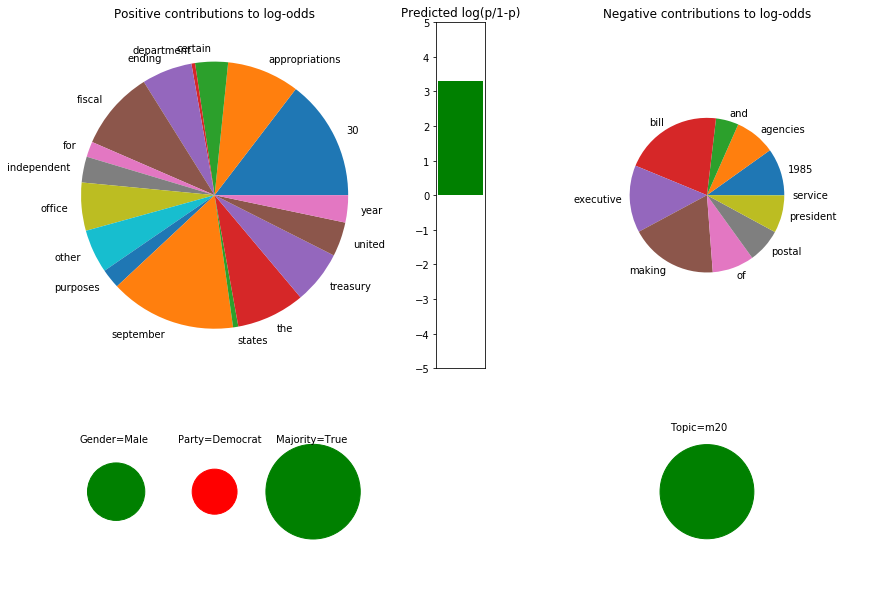

In [14]:
## RERUN THIS CELL to sample new bills from the dev set, and visualize the behavior of the model on them.

# Sample an index.
# idx = np.random.randint(len(dev_df)) # get a uniformly random sentence
idx = np.random.choice(bad_idxs) # get a random mispredicted sentence

row = dev_df.iloc[idx]
# row = row.copy()
# row['Title'] = """this is my custom law. amend the united states constitution to allow forced
# conscription of people in other countries."""

title, label = row['Title'], row['PLaw']
print(title)
features, weights, pred = process_sentence(row)
print('\nPredicted Pr(bill passes) = %.3f, Ground Truth = %.1f.\n' % (pred, label))

display_contributions(features, weights, pred)

## Bill pass rate per word

In [15]:
word = 'commonwealth'
prob = word_success(word)
print('For bills containing the word "%s", Pr(bill passes) = %.3f.' % (word, prob))
print('On average, Pr(bill passes) = %.3f' % df['PLaw'].mean())

For bills containing the word "commonwealth", Pr(bill passes) = 0.089.
On average, Pr(bill passes) = 0.042
